<a href="https://colab.research.google.com/github/hansbrunner/safety_data/blob/main/Clozapine/Clozapine_adverse_event_time_to_onset_and_cumulative_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
In this analysis, I explored various data analysis techniques in the field of drug safety surveillance,
with a particular focus on time-to-onset and cumulative risk of adverse events. These methods provide
insights into when adverse events occur during treatment and how the associated risk builds over time.
Such analyses are important for understanding the safety profiles of medications, such as those used
in therapeutic areas like psychiatry and neurology.

The analysis centered on Clozapine, a potent antipsychotic drug widely used in the treatment of
schizophrenia. While Clozapine is highly effective, it is associated with serious adverse events,
including hematological complications such as granulocytopenia, leukopenia, and neutropenia.
Identifying when these adverse events are most likely to occur is essential for designing effective
clinical monitoring protocols and minimizing patient risk.

Key Findings:
Time-to-Onset Analysis:

Among the adverse events (AEs) reported in over 1% of cases, granulocytopenia, leukopenia, and neutropenia exhibited
median onset times of approximately 1 year, for patients with those AEs.
For patients with other AEs were found to have much longer median onset times, with nearly linear survival curves,
indicating that these events tend to occur more gradually over the course of treatment.

Future Directions:
To further refine this analysis, it would be beneficial to explore how additional factors—such as
different formulations of Clozapine, dosage levels, patient age, gender, and other demographic or
clinical characteristics—affect the risk and timing of these adverse events.
Applying a Cox Proportional Hazards model or machine learning tools could help quantify the influence of these factors on
the onset of AEs, offering a more nuanced understanding of Clozapine’s safety profile.

Through this work, I aim to deepen my understanding of real-world pharmacovigilance data
and enhance my ability to perform complex drug safety analyses using large datasets,
such as those provided by the FDA Adverse Event Reporting System (FAERS).
This ongoing exploration is not only important for improving drug safety assessments
but also for developing practical skills in managing and analyzing real-world healthcare data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# Navigate to file
%cd /content/drive/MyDrive/Colab Notebooks/Clozapine
from my_functions import fetch_fda_data, extract_fda_data

# get data from FDA
data = fetch_fda_data("clozapine", 25000)

# Convert list of json to pandas df
df = extract_fda_data(data)

/content/drive/MyDrive/Colab Notebooks/Clozapine


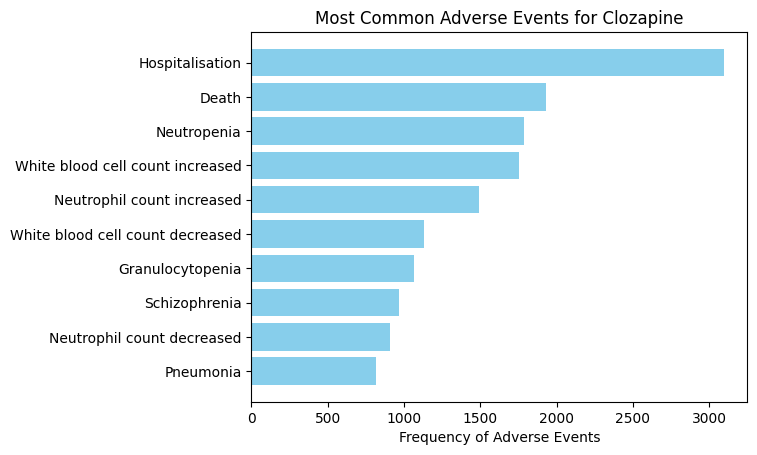

['Hospitalisation', 'Death', 'Neutropenia', 'White blood cell count increased', 'Neutrophil count increased', 'White blood cell count decreased', 'Granulocytopenia', 'Schizophrenia', 'Neutrophil count decreased', 'Pneumonia']


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# # Convert json to pandas df
# df = extract_fda_data(data)

# Find most common AEs
# plot most common PT AE for clozapine
cut_off = df.shape[0] * 0.01 # cut off of 1 percent

# count number of reports for each PT AE
pt_grouped = df.groupby('AE PT').agg(
    total_reports=('Patient #', 'size')
).reset_index()
pt_grouped.sort_values(by='total_reports', ascending=False,inplace=True) # sort
pt_grouped = pt_grouped.loc[pt_grouped["total_reports"]>cut_off]

# Plot a bar chart for the counts of adverse events in PT
plt.figure()
plt.barh(pt_grouped['AE PT'], pt_grouped['total_reports'], color='skyblue')
plt.xlabel('Frequency of Adverse Events')
plt.title('Most Common Adverse Events for Clozapine')
plt.gca().invert_yaxis()  # Most common at the top
plt.show()


list_of_aes = list(pt_grouped['AE PT'])
print(list_of_aes)


In [9]:
# Time-to-event (survival analysis). compute time from treatment start to AE report

# Convert dates to datetime
df['Treatment Start Date'] = pd.to_datetime(df['Treatment Start Date'], errors='coerce')
df['Report Date'] = pd.to_datetime(df['Report Date'], errors='coerce')

# Remove incomplete data
df = df.dropna(subset='Treatment Start Date')

# Calculate days from treatment to report
df['Time to Onset (Days)'] = (df['Report Date'] - df['Treatment Start Date']).dt.days

# Event indicator
df['Event'] = 0
print(df.shape)

(28080, 12)


In [11]:
%pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 6.4 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=38269fa66ad7f2bd2ca99096b8397f8c797e3559bef0d88235df902382ef7fca
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


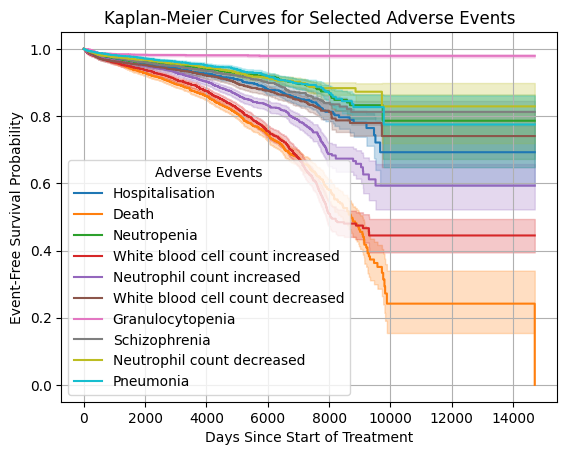

In [12]:
# Kaplan Meier estimator
from lifelines import KaplanMeierFitter

# Loop AEs
for ae in list_of_aes:

    kmf = KaplanMeierFitter()
    df['Event'] = 0 # reset event

    # Set Event based on ae
    df['Event'] = df['AE PT'].apply(lambda x: 1 if x == ae else 0)

    # Make sure each patient only have 1 entrance
    unique_patients = df.groupby('Patient #').agg({
        'Time to Onset (Days)': 'min',
        'Event': 'max'   # Ensure that event is kept, if it happened
    }).reset_index()

    # Fit Kaplan-Meier model
    kmf.fit(durations=unique_patients['Time to Onset (Days)'], event_observed=unique_patients['Event'], label=ae)

    # Plot Kaplan-Meier curve
    kmf.plot_survival_function()

# Add labels and title to the plot
plt.title('Kaplan-Meier Curves for Selected Adverse Events')
plt.xlabel('Days Since Start of Treatment')
plt.ylabel('Event-Free Survival Probability')
plt.grid(True)
plt.legend(title="Adverse Events")
plt.show()

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or i

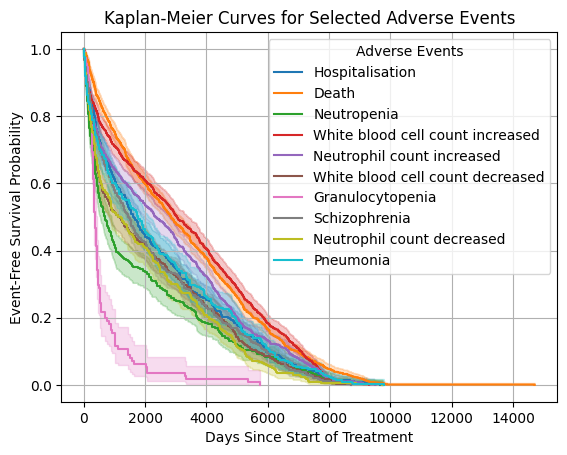

,AE,Median Time (Days),25th Percentile (Days),75th Percentile (Days)
0,Hospitalisation,1618.00,4114.00,447.00
1,Death,2849.00,5085.00,1014.00
2,Neutropenia,676.00,3022.00,209.00
3,White blood cell count increased,3035.00,5327.00,737.00
4,Neutrophil count increased,2341.00,4591.00,449.00
5,White blood cell count decreased,1170.00,3808.00,314.00
6,Granulocytopenia,359.00,541.00,260.00
7,Schizophrenia,1451.00,3828.00,394.00
8,Neutrophil count decreased,1118.00,3637.00,285.00
9,Pneumonia,1751.00,4153.00,375.00


In [13]:
# Kaplain Meier curve, only for patients with the specific AE

summary_stats = []

# Loop AEs
for ae in list_of_aes:

    kmf = KaplanMeierFitter()
    df['Event'] = 0 # reset

    # Set Event based on ae
    df['Event'] = df['AE PT'].apply(lambda x: 1 if x == ae else 0)

    # Make sure each patient only have 1 entrance
    unique_patients = df.groupby('Patient #').agg({
        'Time to Onset (Days)': 'min',
        'Event': 'max'   # Ensure that event is kept, if it happened
    }).reset_index()

    # Only include patients with event
    event_patients = unique_patients[unique_patients['Event'] == 1]

    # Fit the Kaplan-Meier model
    kmf.fit(durations=event_patients['Time to Onset (Days)'], event_observed=event_patients['Event'], label=ae)

    # Extract Metrics
    median_time = kmf.median_survival_time_  # Median time to event (50th percentile)
    percentile_25 = kmf.percentile(0.25)  # 25th percentile
    percentile_75 = kmf.percentile(0.75)  # 75th percentile

    # Keep metrics
    summary_stats.append({
        'AE': ae,
        'Median Time (Days)': median_time,
        '25th Percentile (Days)': percentile_25,
        '75th Percentile (Days)': percentile_75
    })

    # Plot the Kaplan-Meier curve
    kmf.plot_survival_function()

    # Cumulative risk
    survival_function = kmf.survival_function_
    cumulative_risk = 1 - survival_function

# Tidy
plt.title('Kaplan-Meier Curves for Selected Adverse Events')
plt.xlabel('Days Since Start of Treatment')
plt.ylabel('Event-Free Survival Probability')
plt.grid(True)
plt.legend(title="Adverse Events")
plt.show()

# table
summary_df = pd.DataFrame(summary_stats)

table = summary_df.style.format(precision=2).set_caption("Summary of Time Points for Adverse Events")
table
